In [8]:
train = pd.read_csv('../data/gender_age_train.csv', index_col='device_id')

In [9]:
train['group']

device_id
-8076087639492063270    M32-38
-2897161552818060146    M32-38
-8260683887967679142    M32-38
-4938849341048082022    M29-31
 245133531816851882     M29-31
-1297074871525174196    F24-26
 236877999787307864     M32-38
-8098239495777311881    M32-38
 176515041953473526     M32-38
 1596610250680140042    F33-42
 9032155484127182494    M29-31
 7477216237379271436    F33-42
 2478205222798310601    F27-28
 6352067998666467520    M32-38
-7605360767281960867      M39+
 1508636020748379883    F27-28
 4380872794486415327    M32-38
-1039701474753771322    M32-38
-6876541075223249434      M39+
 6287938418661076759    M32-38
-6029676723224952628    F33-42
 8026504930081700361    M23-26
 1118970699362079126    M23-26
-7271319853104672050    M27-28
-9216966316587614491    M29-31
-4913644674161904021    M32-38
 2313145512701915151    M32-38
 4309468945717577632    F33-42
-4547337748907986143    M32-38
-7216269352973401877    M32-38
                         ...  
 7826033719277536366    M27-2

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from keras.models import Sequential, load_model
from keras.layers import Activation,Dense,Dropout,BatchNormalization,PReLU
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import math
from sklearn.metrics import r2_score, mean_squared_error

C:\Users\Student\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Preprocessing

#### Read train and test data 

In [7]:
df_train_x = pd.read_csv('../matrix_for_model/train_x.csv', index_col='device_id')
print(df_train_x.shape)

df_test_x = pd.read_csv('../matrix_for_model/test_x.csv', index_col='device_id')
print(df_test_x.shape)

(74645, 12714)
(112071, 12714)


#### Save index

In [8]:
df_train_id = df_train_x.index
print(df_train_id.shape)

df_test_id = df_test_x.index
print(df_test_id.shape)

(74645,)
(112071,)


#### Normalization

In [28]:
array_train_x = preprocessing.normalize(df_train_x)
array_test_x = preprocessing.normalize(df_test_x) 

#### Standardization

In [10]:
# scaler_train = preprocessing.StandardScaler()
# scaler_train = scaler_train.fit(df_train_x)
# array_train_x = scaler_train.transform(df_train_x)

# scaler_test = preprocessing.StandardScaler()
# scaler_test = scaler_test.fit(df_test_x)
# array_test_x = scaler_test.transform(df_test_x)

#### Prepare train_y

In [3]:
df_train_y = pd.read_csv('../matrix_for_model/train_y.csv', header=None)
print(df_train_y.shape)

(74645, 1)


In [63]:
df_train_y_onehot = pd.get_dummies(df_train_y)
array_train_y = df_train_y_onehot.values
array_train_y.shape

(74645, 12)

#### Feature selection according to random forest

In [29]:
clf = ExtraTreesClassifier(random_state=1).fit(array_train_x, array_train_y)
print("clf.feature_importances_ :",clf.feature_importances_)

clf.feature_importances_ : [0.00000000e+00 4.86535095e-05 5.76219944e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [30]:
col_filter = SelectFromModel(clf,prefit=True,threshold=1.0*(clf.feature_importances_.mean()))
array_train_x = col_filter.transform(array_train_x)
array_train_x.shape

(74645, 1581)

In [31]:
array_test_x = col_filter.transform(array_test_x)
array_test_x.shape

(112071, 1581)

# Model

#### Define function of submit dataframe

In [32]:
def submit_df(df_test_id, array_test_y):
    cols = ['device_id', 'F23-','F24-26','F27-28','F29-32','F33-42','F43+','M22-','M23-26','M27-28','M29-31','M32-38','M39+']
    df_result = pd.DataFrame(columns=cols)
    df_result['device_id'] = df_test_id
    df_result[['F23-','F24-26','F27-28','F29-32','F33-42','F43+','M22-','M23-26','M27-28','M29-31','M32-38','M39+']] = array_test_y
    return df_result

## 1. Backpropagation Neural Network 

#### Define model

In [28]:
def nn_modeling(train_x):
    model = Sequential()
    model.add(Dense(200, input_dim=train_x.shape[1], init='normal'))
    model.add(PReLU())
    model.add(Dropout(0.4))
    model.add(Dense(50, init='normal'))
    model.add(PReLU())
    model.add(Dropout(0.2))
    model.add(Dense(12, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

#### Train model

In [29]:
nn_model = nn_modeling(array_train_x)

/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, input_dim=12714, kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, kernel_initializer="normal")`
  
/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(12, activation="softmax", kernel_initializer="normal")`
  if __name__ == '__main__':


Train on 67180 samples, validate on 7465 samples
Epoch 1/7
67180/67180 [==============================] - 48s 711us/step - loss: 2.4196 - acc: 0.1360 - val_loss: 2.3244 - val_acc: 0.1691
Epoch 2/7
67180/67180 [==============================] - 44s 654us/step - loss: 2.3521 - acc: 0.1676 - val_loss: 2.2820 - val_acc: 0.1914
Epoch 3/7
67180/67180 [==============================] - 46s 685us/step - loss: 2.3180 - acc: 0.1778 - val_loss: 2.2776 - val_acc: 0.1886
Epoch 4/7
67180/67180 [==============================] - 55s 824us/step - loss: 2.2962 - acc: 0.1881 - val_loss: 2.2767 - val_acc: 0.1875
Epoch 5/7
67180/67180 [==============================] - 54s 800us/step - loss: 2.2782 - acc: 0.1970 - val_loss: 2.2792 - val_acc: 0.1909
Epoch 6/7
67180/67180 [==============================] - 47s 704us/step - loss: 2.2613 - acc: 0.2027 - val_loss: 2.2788 - val_acc: 0.1989
Epoch 7/7
67180/67180 [==============================] - 48s 717us/step - loss: 2.2450 - acc: 0.2091 - val_loss: 2.2831 - v

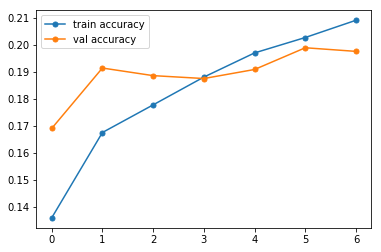

In [30]:
history = nn_model.fit(array_train_x, array_train_y, validation_split=0.1, batch_size=512, epochs=7)
plt.plot(history.history['acc'],ms=5,marker='o',label='train accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

#### Predict test data

In [32]:
array_test_y = nn_model.predict(array_test_x)
df_result = submit_df(df_test_id, array_test_y)
df_result.to_csv('../submit/nn_result.csv', index=False)

## 2. Random Forest

#### Define model

In [33]:
def rf_modeling(train_x, train_y):
    rf = RandomForestRegressor()
    param_grid = { 
    'bootstrap': [True],
    'max_depth': [100],
    'max_features': [3],
    'min_samples_leaf': [4],
    'min_samples_split': [10],
    'n_estimators': [500]
    }
    grid_rf = GridSearchCV(rf, param_grid, n_jobs=-1, cv=3)
    model = grid_rf.fit(train_x, train_y)
    return model

#### Train model

In [36]:
# %env JOBLIB_TEMP_FOLDER=/tmp
forest_model = rf_modeling(array_train_x, array_train_y)

env: JOBLIB_TEMP_FOLDER=/tmp


#### Predict test data

In [37]:
array_test_y = forest_model.predict(array_test_x)
df_result = submit_df(df_test_id, array_test_y)
df_result.to_csv('../submit/forest_result.csv', index=False)

## 3. XGBoost

#### Factorize train_y

In [67]:
factor = pd.factorize(df_train_y[0])
array_train_y = factor[0]
definitions = factor[1]
print(array_train_y)
print(definitions)

[0 0 0 ... 8 0 6]
Index(['M32-38', 'M29-31', 'F24-26', 'F33-42', 'F27-28', 'M39+', 'M23-26',
       'M27-28', 'M22-', 'F43+', 'F23-', 'F29-32'],
      dtype='object')


#### Split train to 90% for training and 10% for validation

In [68]:
train_x, val_x, train_y, val_y = train_test_split(array_train_x, array_train_y, test_size=0.1)
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(67180, 1581)
(67180,)
(7465, 1581)
(7465,)


#### Define model

In [69]:
def xgb_modeling(train_x, train_y, val_x, val_y):
    # Save data to xgb.DMatrix
    data_val  = xgb.DMatrix(val_x, label=val_y)
    data_train = xgb.DMatrix(train_x, label=train_y)
    
    #Set parameters
    param = {}
    param['booster']='gbtree'
    param['objective'] = 'multi:softprob'
    param['tree_method'] = 'hist'
    param['silent']=1
    param['max_depth']= 6
    param['num_class'] = 12
    
    eval_list  = [(data_train,'train'),(data_val,'validation')]
    num_round = 20
    eval_history={}

    # Train model
    xgb_model = xgb.train(param, data_train, num_round, eval_list, 
                          evals_result=eval_history, verbose_eval=False)
    
    #Show process
    mlogloss_train=eval_history['train']['mlogloss']
    mlogloss_validation=eval_history['validation']['mlogloss']
    plt.plot(mlogloss_train,ms=10,marker='.',label='train_eval')
    plt.plot(mlogloss_validation,ms=10,marker='v',label='validation_eval')
    plt.legend()
    plt.show()
    
    # Evaluate result
    print("mlogloss:", xgb_model.eval(data_val))
  
    return xgb_model

#### Train model

In [70]:
xgb_model = xgb_modeling(train_x, train_y, val_x, val_y)

#### Predict test data

In [72]:
x = xgb.DMatrix(array_test_x)
array_test_y = xgb_model.predict(x)
df_result = submit_df(df_test_id, array_test_y)
df_result.to_csv('../submit/xgb_result.csv', index=False)